# DSC parameter estimation (CBV, CBF)

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Test data

Data summary: digital reference object consisting of signal time curves representing perfusion scenarios typical of grey and white matter.

Source: https://github.com/arthur-chakwizira/BezierCurveDeconvolution

Ref: Non-parametric deconvolution using Bézier curves for quantification of cerebral perfusion in dynamic susceptibility contrast MRI

Similar digital reference objects have previously been used in publications evaluating perfusion deconvolution/estimation techniques including Wu et al. 2003 (DOI 10.1002/mrm.10522), Mouridsen et al. 2006 (DOI 10.1016/j.neuroimage.2006.06.015), Chappell et al. 2015 (10.1002/mrm.25390)
    
Detailed info: 
- Transit time distribution: gamma variate distribution with shape parameter lambda = 3 
- delay is not applied yet 

Reference values: Reference values are the parameters used to generate the data. Combinations of CBV (2 and 4) and CBF (5 - 70) are included.

Tolerances
- CBV: a_tol=1, r_tol=0.1
- CBF: a_tol=15, r_tol=0.1


### Visualize test data
To get an impression of the test data, the concentration time curves of the test data are plotted below.

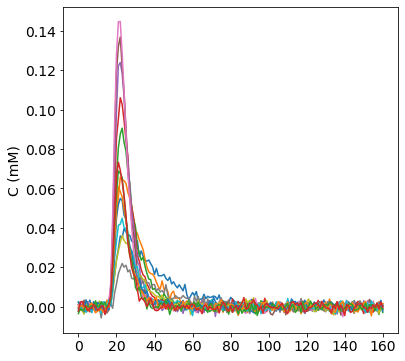

In [2]:
#plot test data
filename = ('../test/DSCmodels/data/dsc_data.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

no_voxels = len(df1.label)
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6,6))
for currentvoxel in range(no_voxels):
    a = df1['C_tis'][currentvoxel]
    c = np.fromstring(a, dtype=float, sep=' ')
    ax.plot(c)
    
ax.set_ylabel('C (mM)', fontsize=14)
#ax.set_xlabel('time (ms)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

    

## Import data

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DSCmodels'):
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
author_list = df.author.unique()
no_authors = len(author_list)

# calculate error between measured and reference values
df['error_cbv'] = df['cbv_meas'] - df['cbv_ref']
df['error_cbf'] = df['cbf_meas'] - df['cbf_ref']

# tolerances
tolerances = { 'cbv': {'atol' : 1, 'rtol': 0.1 }, 'cbf': {'atol':15, 'rtol':0.1}}

## Results

If the tolerance lines are not shown, it means that they are outside the limits of the y-axis.

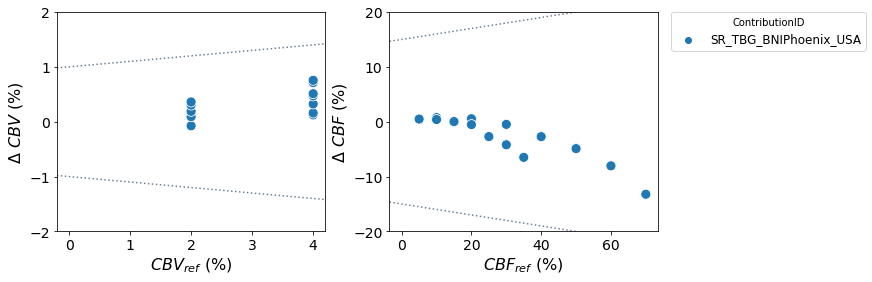

In [6]:
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,4))
plot_bland_altman(ax[0], df, tolerances, 'cbv', ylim=(-2,2),label_xaxis='$CBV_{ref}$ (%)',label_yaxis='$\Delta$ $CBV$ (%)')
plot_bland_altman(ax[1], df, tolerances, 'cbf', ylim=(-20,20),label_xaxis='$CBF_{ref}$ (%)',label_yaxis='$\Delta$ $CBF$ (%)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);



Bias results estimated CBV values combined for all voxels

In [7]:
resultsBA = bland_altman_statistics(data=df,par='error_cbv',grouptag='author')
print(resultsBA)

                           bias     stdev  LoA lower  LoA upper
author                                                         
SR_TBG_BNIPhoenix_USA  0.312242  0.236365  -0.151033   0.775517


Bias results estimated CBF values combined for all voxels

In [8]:
resultsBA = bland_altman_statistics(data=df,par='error_cbf',grouptag='author')
print(resultsBA)

                          bias     stdev  LoA lower  LoA upper
author                                                        
SR_TBG_BNIPhoenix_USA -2.93965  4.107339 -10.990034   5.110734


Bias results estimated $f_p$ values combined for all voxels

## Notes
Additional notes/remarks

### References